# Multi-view Vs Single-view Visualization and Clustering

Here, we directly compare multi-view methods available within *mvlearn* to analagous single-view methods. Using the UCI Multiple Features Dataset, we first examine the dataset by viewing it after using dimensionality reduction techniques, then we perform unsupervised clustering and compare the results to the analagous single-view methods.

In [2]:
from mvlearn.datasets import load_UCImultifeature
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load 6-view, 4-class data from the Multiple Features Dataset. The full 6 views with all features will be used for clustering.

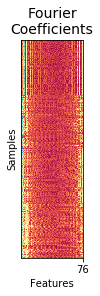

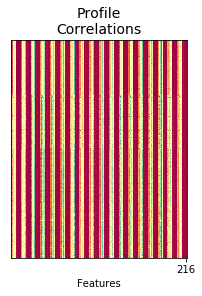

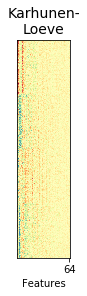

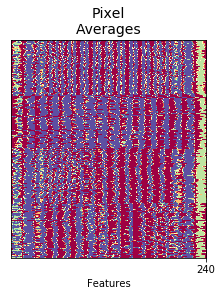

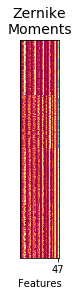

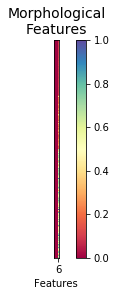

In [3]:
# Load 4-class, multi-view data
Xs, y = load_UCImultifeature(select_labeled=[0,1,2,3])
#     Six views of handwritten digit images
#     1. 76 Fourier coefficients of the character shapes
#     2. 216 profile correlations
#     3. 64 Karhunen-Love coefficients
#     4. 240 pixel averages of the images from 2x3 windows
#     5. 47 Zernike moments
#     6. 6 morphological features
view_names = ['Fourier\nCoefficients', 'Profile\nCorrelations', 'Karhunen-\nLoeve',
              'Pixel\nAverages', 'Zernike\nMoments', 'Morphological\nFeatures']

order = np.argsort(y)
sub_samp = np.arange(0, Xs[0].shape[0], step=3)
set_aspect = 'equal'  # 'equal' or 'auto'
set_cmap = 'Spectral' 

#row_orders = np.argsort(y)
for i, view in enumerate(Xs):
    sorted_view = view[order,:].copy()
    sorted_view = sorted_view[sub_samp,:]
    if set_aspect == 'auto':
        plt.figure(figsize=(1.5,4.5))
    else:
        plt.figure()

    # Scale matrix to [0, 1]
    minim = np.min(sorted_view)
    maxim = np.max(sorted_view)
    sorted_view = (sorted_view - minim) / (maxim - minim)
        
    plt.imshow(sorted_view, cmap=set_cmap, aspect=set_aspect)
    #plt.title('View {}'.format(i+1))
    plt.title(view_names[i], fontsize=14)
    plt.yticks([], "")
    max_dim = view.shape[1]
    plt.xticks([max_dim-1], [str(max_dim)])
    if i == 0:
        plt.ylabel('Samples')
    if i == 5:
        plt.colorbar()
    plt.xlabel('Features')
    plt.show()


Define a function to rearrange the predicted labels so that the predicted class '0' corresponds better to the true class '0'. This is only used so that the colors generated by the labels in the prediction plots can be more easily compared to the true labels.

In [3]:
from sklearn.metrics import confusion_matrix

def rearrange_labels(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    maxes = np.argmax(conf_mat, axis=0)
    y_pred_new = np.zeros_like(y_pred)
    for i, new in enumerate(maxes):
        y_pred_new[y_pred==i] = new
    return y_pred_new

## Comparing Dimensionality Reduction Techniques

As one might do with a new dataset, we first visualize the data in 2 dimensions. For multi-view data, rather than using PCA, we use Multi-view Multi-dimensional Scaling (MVMDS) available in the package to capture the common principal components across views. This is performed automatically within the quick_visualize function. From the unlabeled plot, it is clear that there may be 4 underlying clusters, so unsupervised clustering with 4 clusters may be a natural next step in analyzing this data.

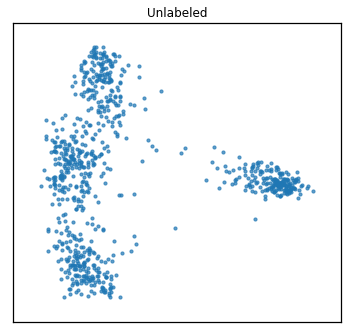

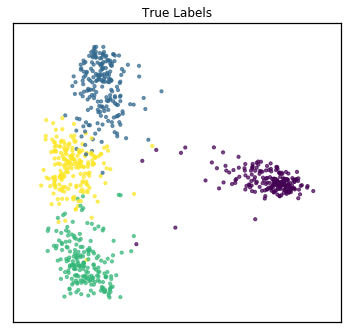

In [4]:
from mvlearn.plotting import quick_visualize

# Use all 6 views available to reduce the dimensionality, since MVMDS is not limited
sca_kwargs = {'alpha' : 0.7, 's' : 10}

quick_visualize(Xs, title="Unlabeled", ax_ticks=False,
                ax_labels=False, scatter_kwargs=sca_kwargs)
quick_visualize(Xs, labels=y, title="True Labels", ax_ticks=False,
                ax_labels=False, scatter_kwargs=sca_kwargs)

As a comparison, we concatenate the views and use PCA to reduce the dimensionality. From the unlabeled plot, it is much less clear how many underlying classes there are, so PCA was not as useful for visualizing the data if our goal was to determine underlying clusters.

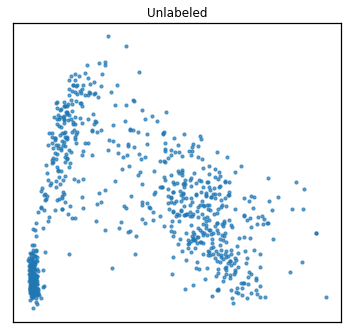

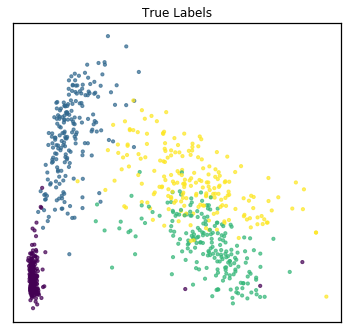

In [5]:
from sklearn.decomposition import PCA

# Concatenate views to get naive single view
X_viewing = np.hstack([Xs[i] for i in range(len(Xs))])

# Use PCA for dimensionality reduction on the naive single view
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X_viewing)

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Unlabeled")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], c=y, **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("True Labels")
plt.show()

## Comparing Clustering Techniques using the Full Feature Space

Now, assuming we are trying to group the samples into 4 clusters (as was much more obvious after using *mvlearn*'s dimensionality reduction viewing method), we compare multi-view clustering techniques to single-view counterparts. Specifically, we compare 6-view spectral clustering in *mvlearn* with single view spectral clustering from *scikit-learn*. For multi-view clustering, all 6 full views of data (not the dimensionality-reduced data). For single-view comparison, we concatenate these 6 full views into a single large matrix, the same as what we did before for PCA.

Since we have the true class labels, we assess the clustering accuracy with a homogeneity score.

Multi-view homogeneity score: 0.962


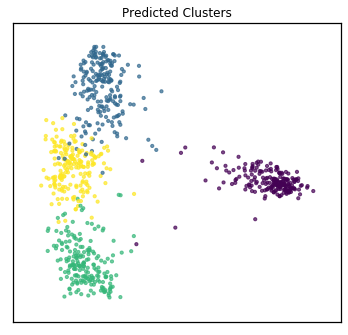

In [6]:
from mvlearn.cluster import MultiviewSpectralClustering

mv_clust = MultiviewSpectralClustering(n_views=6, n_clusters=4, affinity='nearest_neighbors')
mvlearn_cluster_labels = mv_clust.fit_predict(Xs)

# Test the accuracy of the clustering
from sklearn.metrics import homogeneity_score
mv_score = homogeneity_score(y, mvlearn_cluster_labels)
print('Multi-view homogeneity score: {0:.3f}'.format(mv_score))

# Use function defined at beginning of notebook to rearrange the labels
# for easier visual comparison to true labeled plot
mvlearn_cluster_labels = rearrange_labels(y, mvlearn_cluster_labels)

# Visualize the clusters in the 2-dimensional space
quick_visualize(Xs, labels=mvlearn_cluster_labels, title="Predicted Clusters",
                ax_ticks=False, ax_labels=False, scatter_kwargs=sca_kwargs)

To compare to single-view methods, we concatenate the 6 views we used for co-clustering into one data matrix, and then perform spectral clustering using the *scikit-learn* library. From the figure and cluster scores that are produced, we can see that single-view spectral clustering is unable to perform as well as the multi-view version.

Single-view homogeneity score: 0.703


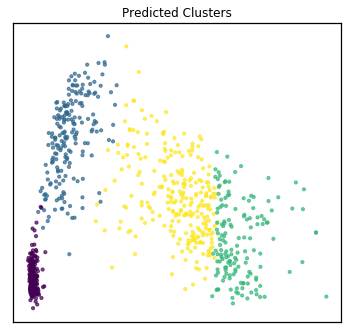

In [7]:
from sklearn.cluster import SpectralClustering

# Concatenate views and cluster
X_clustering = X_viewing
clust = SpectralClustering(n_clusters=4, affinity='nearest_neighbors')
sklearn_cluster_labels = clust.fit_predict(X_clustering)

# Test the accuracy of the clustering
sk_score = homogeneity_score(y, sklearn_cluster_labels)
print('Single-view homogeneity score: {0:.3f}'.format(sk_score))

# Rearrange for easier visual comparison to true label plot
sklearn_cluster_labels = rearrange_labels(y, sklearn_cluster_labels)

# Use PCA for dimensionality reduction on the naive single view
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X_viewing)

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], c=sklearn_cluster_labels, **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Predicted Clusters")
plt.show()